In [1]:
# Imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### We are using a convolutional neural network for this task
More info: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

#### We could have used a regular fully-connected network as well, but this performs better and reduces compute complexity

In [2]:
# Define our network
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        
        # Convolutional layers defined as (in_channels, out_channels, kernel_size, stride)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        # Fully connected linear layers defined as (in_units, out_units)
        self.fc1 = nn.Linear(18*18*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
        # Non-linear activation. It is the function y = max(0, x)
        self.relu = nn.ReLU()
        
        # Pool after convolution, makes the network translation invariant as well as reducing complexity
        self.pool = nn.MaxPool2d(2, stride=1) 

    def forward(self, x):
        x = self.relu(self.conv1(x)) # Calculate linear convolution that pass through non-linear function
        x = self.pool(x) # Get the max of each 2 by 2 square
        x = self.relu(self.conv2(x)) # Repeat for second layer with more channels
        x = self.pool(x) # Pool again
        x = x.view(-1, 18*18*50) # Transform from 2D matrix to a vector for fully-connected layers
        x = self.relu(self.fc1(x)) # Pass through fully connected linear layer and apply non-linear function
        x = self.fc2(x) # Pass through linear layer. DON'T APPLY NON-LINEAR ON LAST LAYER
        return F.log_softmax(x, dim=1) # Use softmax to transform outputs to probabilities

In [3]:
# Define linear network
class Linear_Net(nn.Module):
    def __init__(self):
        super(Linear_Net, self).__init__()
        
        # Fully connected linear layers defined as (in_units, out_units)
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 10)
        
        # Non-linear activation. It is the function y = max(0, x)
        self.relu = nn.ReLU()

    def forward(self, x):
#         print(x.shape) # !!!!! BEST WAY TO DEBUG ISSUES, PRINT SHAPES OF THE TENSORS !!!!!
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x)) # Pass through fully connected linear layer and apply non-linear function
        x = self.fc2(x) # Pass through linear layer. DON'T APPLY NON-LINEAR ON LAST LAYER
        return F.log_softmax(x, dim=1) # Use softmax to transform outputs to probabilities (log_softmax performs better)

In [4]:
# Training function
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0 # Accumulate loss from every batch for the whole epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # Reset accumulated gradient before computing again
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='sum') # Calculate loss (error)
        loss.backward() # Calculate the gradients for weights (Backward pass)
        optimizer.step() # Make the optimizer perform a descent step using the gradient calculated
        epoch_loss += loss.item()
        
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return epoch_loss / len(train_loader.dataset)

In [5]:
# Test function
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [6]:
args = {'batch_size': 10000, # How many images per batch. 
                             # A batch is the set of images for which we perform gradient descent on at once. 
                            # We go through the whole dataset in batches.
        
        'test_batch_size': 1000, 
        'epochs': 10, # Number of times we should go through the whole dataset and train
        'lr': 0.001, # Learning rate
        'momentum': 0.5, # Momentum term for the SGD optimizer
        'seed': 4, # Random seed
        'log_interval': 10, # Batch interval at which we should log to the terminal
        'optim': 'Adam', # Optimizer selection
        'save_model': False, # Save model to a file
        'linear': False} # Use linear model if True, convolutional if False

In [7]:
# Initialize loaders. These load the data from the specified files into memory.
kwargs = {'num_workers': 2, 'pin_memory': True} # If using CUDA, if not make it empty as it doesn't matter

# Training data is used for optimizing the weights in the network
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
               transform=transforms.Compose([
                   transforms.ToTensor()
               ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

# Test data is unseen by the network and is NOT used for changing the weights
# This allows us to see how well the network does on new data and if it generalizes or not
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                   transforms.ToTensor()
               ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

### To load custom datasets follow the guide: https://github.com/utkuozbulak/pytorch-custom-dataset-examples
* Load all items at once in \_\_init__ if dataset fits on memory.
* If the whole dataset doesn't fit on the memory load them from separate files in batches in the \_\_getitem__ function.

In [8]:
# Set a random seed for initalizing the weights so you get the same results every time
torch.manual_seed(args['seed'])

# Set the computation device
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu") # Specify if GPU will be used or only CPU

In [9]:
# Create the model and move it to the device.
model = Linear_Net().to(device) if args['linear']  else Conv_Net().to(device)

# Choose the optimizer
# SGD is the classic Stochastic Gradient Descent algorithm and it works well
# Adam is a newer optimizer method that has adaptive learning weights for each weight and has momentum
if args['optim'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
elif args['optim'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# Train and test for the number of epochs
train_losses = []
test_losses = []
for epoch in range(1, args['epochs'] + 1):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss = test(args, model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

if (args['save_model']):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 23045.927734

Test set: Average loss: 0.7823, Accuracy: 7857/10000 (79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 7930.661133

Test set: Average loss: 0.3591, Accuracy: 8929/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 3625.778320

Test set: Average loss: 0.2356, Accuracy: 9313/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2709.160645

Test set: Average loss: 0.1696, Accuracy: 9500/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1772.752197

Test set: Average loss: 0.1323, Accuracy: 9629/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1434.224609

Test set: Average loss: 0.0996, Accuracy: 9699/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1212.413696

Test set: Average loss: 0.0842, Accuracy: 9734/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 995.245667

Test set: Average loss: 0.0704, Accuracy: 9780/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 826.454590

Test set: Average loss: 0.0617, Accuracy: 9802/10000 (98%)

Train Epoch: 10 [0/6

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

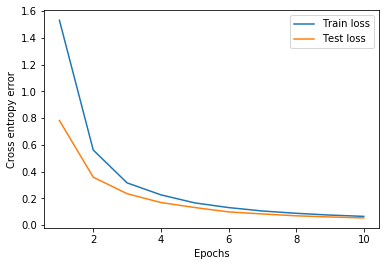

In [11]:
x = list(range(1, args['epochs']+1))
l1, = plt.plot(x, train_losses, label='Train loss')
plt.plot(x, test_losses, label='Test loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross entropy error')
plt.show()

In [14]:
# This is how you load the previously saved model
# .cpu() means we are not using a GPU
model = Conv_Net().cpu()
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()
data = iter(test_loader)
inputs, targets = next(data)

Network guessed 2


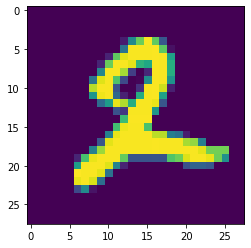

In [15]:
test_on = 331
image = inputs[test_on].view(1, 1, 28, 28)
plt.imshow(image.view(28,28))
guess = model(image).argmax(dim=1).item()
print(f'Network guessed {guess}')